In [104]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from os.path import join as oj
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from random import randint
from style import *
from captum.attr import *
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF, LatentDirichletAllocation
from transform_wrappers import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
import pandas as pd
from models import FNN
import attributions
device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
out_dir = '/scratch/users/vision/data/cosmo/sim'
dirs = sorted(os.listdir(out_dir))

In [106]:
results_list = []
for dirname in dirs:
    fname = os.listdir(oj(out_dir, dirname))[0]
    results_list.append(pkl.load(open(oj(out_dir, dirname, fname), 'rb')))
results = pd.DataFrame(results_list)
results.insert(0, 'dir', dirs)

In [107]:
results

,dir,acc_test,data_distr,idx_knockout,lr,n,n_test,net,num_components,num_epochs_train,out_dir,p,pid,results,transform,window
0,fft,0.95216,NaN,12,NaN,50000,2000,"FNN(\n (fc1): Linear(in_features=100, out_fea...",NaN,NaN,/scratch/users/vision/data/cosmo/sim,100,66257609305319508671,...,irfft,0
1,fft_unif,0.87856,uniform,12,0.10,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/fft_unif,100,86068516496196794951,...,fft,0
2,lda,0.95888,NaN,12,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/lda,100,08722341460397210112,...,irfft,0
3,nmf2,0.94416,NaN,12,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/nmf2,100,37451272574898306406,...,irfft,0
4,nmf_unif,0.97232,uniform,12,0.01,50000,500,"FNN(\n (fc1): Linear(in_features=100, out_fea...",30.0,12.0,/scratch/users/vision/data/cosmo/sim/nmf_unif,100,00333110602630352729,...,nmf,0


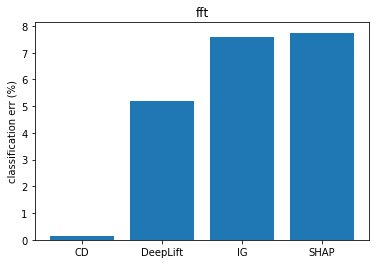

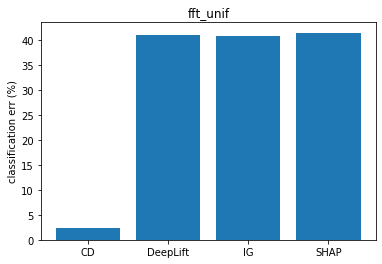

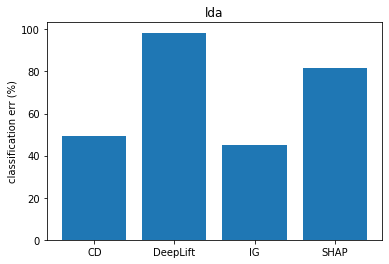

In [108]:
colors = [cb, cr, 'purple', 'green']
plt.figure(facecolor='white')

R = 3
for i in range(R):
    row = results.iloc[i]
    r = row['results']

    accs = []
    ks = sorted(r.keys())
    for k in ks:
        vals = np.vstack(r[k])
        args = np.argmax(vals, axis=1)
        num_correct = np.sum(args == row['idx_knockout'])
        accs.append(num_correct / vals.shape[0])
        
    plt.title(row.dir)
    plt.bar(ks, (1-np.array(accs)) * 100)
    plt.ylabel('classification err (%)')
    plt.show()

In [25]:
prob = 0.948
num = 1000
print(np.sqrt(prob * (1-prob)) / np.sqrt(num))

0.007021111023192843


In [26]:
# d = scores.size
# idxs = np.zeros(d).astype(bool)
# idxs[idx_zero - window: idx_zero + window + 1] = 1
# plt.plot(np.arange(d)[idxs], scores[idxs], 'o')
# plt.plot(np.arange(d)[~idxs], scores[~idxs], 'o')
# plt.show()